# Weighted K Nearest Neighbors

Algorithm: compute the K nearest neighbors of a trajectory as the predicted trajectories

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import multiprocessing as mp

In [4]:
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.visualization.visualize_sequences import viz_sequence
from IPython.display import clear_output

In [5]:
'''
#root_dir = '/home/aaron/workspace/argoverse/data/forecasting_sample_v1.1/forecasting_sample/data'
root_dir = '/home/aaron/workspace/argoverse/data/forecasting_train_v1.1/train/data'
afl = ArgoverseForecastingLoader(root_dir)
avm = ArgoverseMap()
print('Total number of sequences:',len(afl))
'''

"\n#root_dir = '/home/aaron/workspace/argoverse/data/forecasting_sample_v1.1/forecasting_sample/data'\nroot_dir = '/home/aaron/workspace/argoverse/data/forecasting_train_v1.1/train/data'\nafl = ArgoverseForecastingLoader(root_dir)\navm = ArgoverseMap()\nprint('Total number of sequences:',len(afl))\n"

In [6]:
def normalize_trajectory(traj):
    norm_traj = traj - traj[0]
    theta = -np.arctan2(norm_traj[-1][1],norm_traj[-1][0])
    rot_mat = ((np.cos(theta), -np.sin(theta)), (np.sin(theta), np.cos(theta)))
    norm_traj = np.matmul(rot_mat, norm_traj.T).T
    return norm_traj

In [7]:
def normalize_trajectory_caller(args):
    idx, agent_traj = args
    if idx % 1000 == 0:
        print(idx)
    norm_traj = normalize_trajectory(agent_traj)
    return idx, norm_traj

In [8]:
'''
num_workers = mp.cpu_count()//2
pool = mp.Pool(num_workers)
args = [(idx, traj.agent_traj) for idx, traj in enumerate(afl)]
res = pool.map(normalize_trajectory_caller, args)
lookup = sorted(res,key=lambda x:x[0])
np.save('lookup.npy', lookup)
'''

"\nnum_workers = mp.cpu_count()//2\npool = mp.Pool(num_workers)\nargs = [(idx, traj.agent_traj) for idx, traj in enumerate(afl)]\nres = pool.map(normalize_trajectory_caller, args)\nlookup = sorted(res,key=lambda x:x[0])\nnp.save('lookup.npy', lookup)\n"

In [9]:
def get_top_k(target_traj, lookup, k=6):
    norm_target_traj = normalize_trajectory(target_traj)
    distances = np.subtract(lookup[:,:20], norm_target_traj[:20])
    distances = np.linalg.norm(distances, axis=(1,2))
    top_k_idxs = np.argsort(distances)
    return distances, top_k_idxs[:k]

In [202]:
def correct_prediction(predict_traj, agent_traj):
    agent_dx = agent_traj[19,0] - agent_traj[18,0]
    agent_dy = agent_traj[19,1] - agent_traj[18,1]
    target_x = agent_traj[19,0] + agent_dx
    target_y = agent_traj[19,1] + agent_dy
    shift_x = target_x - predict_traj[20,0]
    shift_y = target_y - predict_traj[20,1]
    predict_traj[:,0] += shift_x
    predict_traj[:,1] += shift_y
    return predict_traj

In [207]:
def get_multiple_forecasts(data, lookup, k=6, plot=False):
    predictions = list()
    agent_traj = data.agent_traj
    norm_agent_traj = agent_traj - agent_traj[0]
    print(f'norm_agent_traj: {norm_agent_traj[-19]}')
    distances, top_k_idxs = get_top_k(agent_traj, lookup, k=6)
    if plot:
        plt.figure()
        #ax = plt.gca().set_aspect('equal')
        # plot starting point
        plt.plot(agent_traj[0,0], agent_traj[0,1], '-o', c='r')
        plt.plot(agent_traj[:20,0], agent_traj[:20,1],c='r')
    for k in top_k_idxs:
        predict_traj = lookup[k]
        
        # using cosine dot product relation to determine angular difference between trajectories
        arg = np.dot(predict_traj[19], norm_agent_traj[19])/ np.linalg.norm(predict_traj[19])/np.linalg.norm(norm_agent_traj[19])
        theta = np.arccos(np.clip(arg, -1.0, 1.0))
        if norm_agent_traj[19,1] < 0:
            theta *= -1
        rot_mat = ((np.cos(theta), -np.sin(theta)), (np.sin(theta), np.cos(theta)))
        t_predict_traj = np.matmul(rot_mat, predict_traj.T).T + agent_traj[0]
        if np.linalg.norm(t_predict_traj[20]-agent_traj[19]) > 0.5:
            t_predict_traj = correct_prediction(t_predict_traj, agent_traj)
        t_predict_traj[:20] = agent_traj[:20]
        predictions.append(t_predict_traj)
        if plot:
            # plot predicted trajectories
            plt.plot(t_predict_traj[:20,0], t_predict_traj[:20,1],c='r')
            plt.plot(t_predict_traj[19:,0], t_predict_traj[19:,1],c=np.random.random(3,))
#     plt.figure()
#     plt.plot(norm_agent_traj[:,0], norm_agent_traj[:,1],c='r')
#     for k in top_k_idxs:
#         plt.plot(lookup[k,:,0], lookup[k,:,1], c=np.random.random(3,))
    return np.asarray(predictions)
    

In [11]:
def get_multiple_forecasts_caller(args):
    idx, data, lookup = args
    clear_output()
    print(f'{idx}/78143')
    return idx, get_multiple_forecasts(data, lookup)

In [179]:
root_dir = '/home/aaron/workspace/argoverse/data/forecasting_val_v1.1/val/data'
#root_dir = '/home/aaron/workspace/argoverse/data/forecasting_sample_v1.1/forecasting_sample/data'
afl = ArgoverseForecastingLoader(root_dir)
lookup = np.load('lookup.npy', allow_pickle=True)

norm_agent_traj: [  0.46666952 -54.85167426]


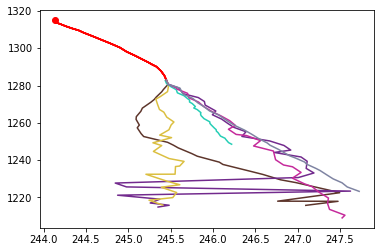

In [216]:
idx = np.random.randint(len(afl))
predictions = get_multiple_forecasts(afl[idx], lookup, plot=True)

34541


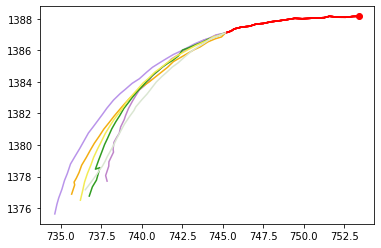

In [120]:
print(idx)
#viz_sequence(afl[idx].seq_df)
predictions = get_multiple_forecasts(afl[idx], lookup, plot=True)

In [ ]:
output_all = dict()
counter = 1
for data in afl:
    print('\r'+str(counter)+'/'+str(len(afl)),end="")
    predictions = get_multiple_forecasts(data, lookup)
    seq_id = int(data.current_seq.name[:-4])
    output_all[seq_id] = predictions[:,20:,:]
    counter += 1
np.save('knn_baseline_output_all.npy', output_all)

47643/78143

In [ ]:
'''
num_workers = mp.cpu_count()//2
pool = mp.Pool(num_workers)
args = [(idx, data, lookup) for idx, data in enumerate(afl)]
res = pool.map(get_multiple_forecasts_caller, args)
output_all = sorted(res,key=lambda x:x[0])
np.save('knn_baseline_output_all.npy', output_all)
'''

In [ ]:
'''
output_all_list = np.load('knn_baseline_output_all.npy', allow_pickle=True)
output_all = dict()
for idx, data in enumerate(afl):
    seq_id = int(data.current_seq.name[:-4])
    output_all[seq_id] = output_all_list[idx,:,20:,:]
seq_id = int(afl[0].current_seq.name[:-4])
print(output_all[seq_id])
'''

In [ ]:
from argoverse.evaluation.competition_util import generate_forecasting_h5

output_path = 'competition_files/'

generate_forecasting_h5(output_all, output_path, filename='knn_baseline') #this might take awhile